# II - Redes Densas

## Importar librerias

In [1]:
# Arrancamos importando herramientas generales

import numpy as np
import time # para hacer medición de tiempos
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
# Dentro del módulo de tensorflow tenemos el submódulo de Keras
# donde nos importamos diferentes herramientas
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.metrics import MSE
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras.utils import to_categorical

# Dataset dentro de Keras que se llama mnist que ya
# viene con todas las herramientas que necesitamos
# para cargar los datos
from tensorflow.keras.datasets import mnist

## Parametros de entrenamiento
Habían ciertos parámetros del entrenamiento que eran importantes, arrancamos el ejemplo seteando esos parámetros

In [3]:
# LEARNING RATE: tasa a la cual la RN aprende en 
#    ES UN        cada paso de backpropagation. 
# HIPERPARÁMETRO  no hay una manera cierta de setear
#                 un lr. 1.0 es un valor estándar
#                 si es un num muy bajo, la red aprende
#                 poco en cada paso. Vamos a necesitar
#                 muchas iteraciones. Si es muy alto,
#                 el problema puede diverger. Empiezan
#                 a oscilar los pesos. Encontrar el
#                 valor óptimo es un proceso iterativo

lr = 1.0

# NUMERO DE EPOCAS: iteracion en la cual la RN ve el
#                   total de ejemplos de entrenamiento
#                   La RN ve 30 veces los ejs de 
#                   entrenamiento
epochs = 30

# TAMAÑO DE BATCH: la red va a ver 256 ejemplos hacia
#                  adelante, se calcula el error medio
#                  y ese error medio se retropropaga
#                  se repite una cant de veces hasta
#                  completar una epoca.
batch_size = 256

# SEMILLA de la generación pseudoaleatoria de los 
#         números. La red arranca con pesos (conexiones)
#         que tienen valores totalmente aleatorios
#         como le puse el '14' siempre tengo el 
#         mismo rtado
np.random.seed(14)

## Cargar y visualizar el dataset

In [4]:
# DATASET: MNIST
# consta de una serie de digitos manuscritos a los cuales
# está asociado una etiqueta.

# Usando el método load_data() obtenemos dos tuplas:
# - una con los datos de entrenamiento
# - otra con los datos de validación (más chiquito)

# tenemos 10 clases para resolver el problema de clasificación
# son dígitos que van desde el 0 al 9
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# obtengo la cant de etiquetas única que están en el conj
# de entrenamiento
n_classes = np.max(np.unique(y_train)) + 1
print(n_classes) 

10


In [5]:
# tenemos 60 mil datos de entrenamiento
# con un alto y ancho de imagen de 28*28 pixeles
x_train.shape

(60000, 28, 28)

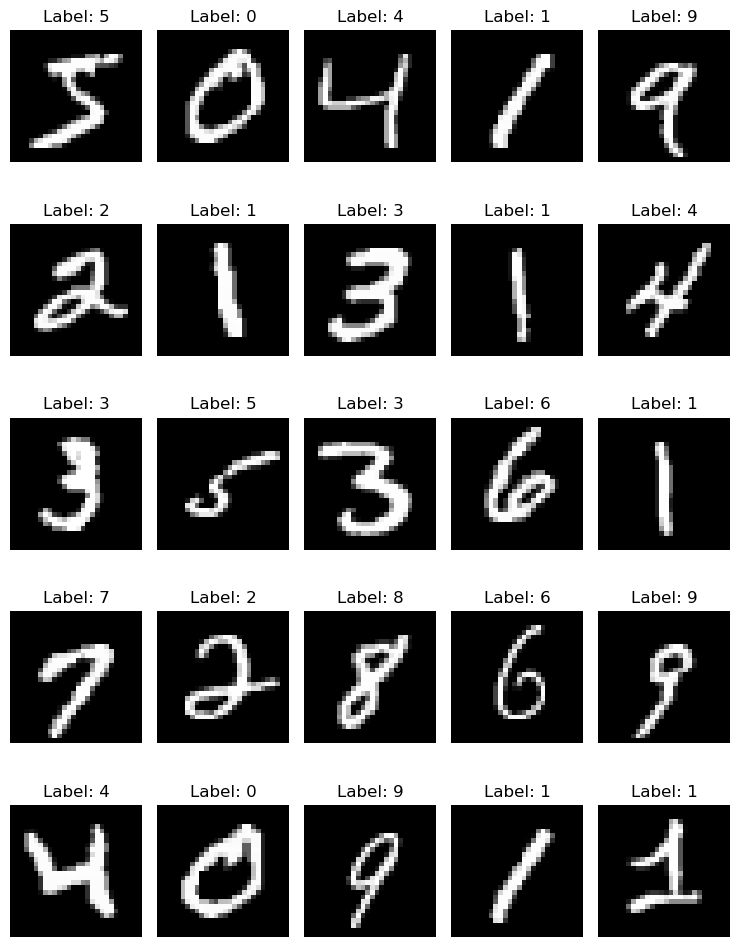

In [6]:
# Este código hace uso de matplot lib y puplot para
# graficar este conjunto de dígitos manuscritos
num = 25
images = x_train[:num]
labels = y_train[:num]
num_row = 5
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap = 'gray')
    ax.set_title('Label: {}'.format(labels[i]))
    ax.axis('off')
plt.tight_layout()
plt.show()

## Preparacion de los datos

In [7]:
# Cantidad de neuronas que conforman la capa de entrada
28*28

784

In [8]:
# Estamos trabajando con IMAGENES.
# Algunos recaudos:
# - distribuidas en un array de 28*28 pixeles
# - para entrar a nuestra RN, tenemos un num de neuronas
#   que conforman la capa de entrada. Hay que aplastar 
#   las imágenes

# Los valores de cada pixeles van dde 0 a 255 (8 bits)
# 0: negro
# 255: blanco
# valores entre medio: escala de los grises

# Nosotros no queremos trabajar en ese rango. Queremos
# trabajar en solamente 0: negro, 1: blanco, pq la red
# acotado

# Pasamos los valores de cada pixeles a un valor decimal
# transformamos en float32 (es un tipo decimal)
# luego dividimos por el tope de la escala de grises
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [9]:
y_train[123]

# La capa de salida tiene una neurona por cada clase
# Tenemos 10 clases => tenemos 10 neuronas en la capa de salida
# queremos que (en este caso) la neurona 7 'se prenda'
# y nos devuelva un 1 en esa neurona

7

In [10]:
# Usamos la función to_categorical()
# Lleva las categorias a una forma categórica

y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes) #one-hot encoding

In [11]:
y_train[123]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [12]:
# Ultima transformación
# pasar de una imagen 2D a una entrada que sea 1D
# Aplastamos la imagen, transformando el shape
# Conservamos la # de filas
# La cant de columnas es el producto de todas las 
# dimensiones restantes a partir de la 1

x_train.shape = (x_train.shape[0], np.prod(x_train.shape[1:]))
x_test.shape = (x_test.shape[0], np.prod(x_test.shape[1:]))

In [13]:
x_train.shape

# A partir de ahora, lo que tenemos son:
# - 784 neuronas de entrada
# - capas de procesamiento ocultas
# - 10 neuronas de salida

(60000, 784)

## Crear el modelo
Hacemos uso de la interfaz de Keras

In [14]:
# Model
#---------------------------------------------------------------------#

# Instanciamos una clase que se llama INPUT (la capa de entrada)
# Le tenemos que dar la dimension de la capa de entrada 
# (la cant de neuronas de la capa de entrada)
input_layer = Input(shape = x_train.shape[1:])

# Instanciamos otra capa (oculta) llamando la clase DENSE
# Son capas totalmente conexas
# Le digo el numero de neuronas que tiene que tener esa capa
# --> es un numero totalmente arbitrario
# --> hay que ir probando
# La funcion de activacion: relu. Es lineal rectificada (rampa)
# es diferenciable por partes.
# toma como input los elementos de la capa anterior
dense_1 = Dense(500, activation = 'relu') (input_layer)

dropout_1 = Dropout(0.25) (dense_1) # ctrl + /

dense_2 = Dense(500, activation = 'relu') (dropout_1)

dropout_2 = Dropout(0.25) (dense_2)

dense_3 = Dense(100, activation = 'relu') (dropout_2)

dropout_3 = Dropout(0.25) (dense_3)

# capa de salida. Tantas neuronas como clase tiene nuestros problemas
# funcion de activacion que se llama SOFTMAX: devuelve valores entre 0 y 1
# la suma total de esos 10 elementos es igual a 1. Se interpreta como una probabilidad
# nos devuelve la probabilidad de que un ejemplo pertenezca a tal o cual clase
output_layer = Dense(n_classes, activation='softmax') (dropout_3)
#---------------------------------------------------------------------#

model = Model(input_layer, output_layer)



# LAS CAPAS DE DROPOUT desconectan un numero de esas conexiones de manera aleatoria.
# En este caso, desconecta el 25%
# Sentido que tiene: simplifica el modelo
# Hace que el modelo corra más rapido, y que el modelo se vuelva menos propenso a sobreajustR
# los datos de entrenamiento ==> disminuye el gap
# Debido a que estamos cortando conexiones, el accuracy sobre el conjunto de
# entrenamiento es menor al que esperaríamos, pero logramos acortar el overfiting



In [15]:
# Se especifica una función de costo con un optimizador y unas métricas
# Los optimizadores resuelven el problema de oprimizacion
# en el cual los pesos van tendiendo hacia un valor que sea el óptimo

# Optimizador más corriente/ normal:
# GRADIENTE DESCENDIENTE ESTOCÁSTICO --> descendemos en la direc del gradiente
# hasta llegar a un valor óptimo

# Aca usamos otro que se llama ADADELTA
# rho tiene que ver con el momento estocástico
Adadelta_optimizer = Adadelta(learning_rate=lr, rho=0.95)

# loss: costo de la red neuronal. Funcion de error asociada a la 
#       salida para hacer la retropropagacion
# Metricas: accuracy, mse: mean square error (promedio de los errores al cuadrado)
model.compile(optimizer = Adadelta_optimizer, loss='categorical_crossentropy', metrics=['acc', 'mse'])

# Sumario del modelo creado
model.summary()

# Funcion del optimizador: hacer que ese modelo en el proceso de retropropagación 
#                          vaya tendiendo a los valores óptimos de los pesos de la RN 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 500)               392500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               50100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0     

## Entrenar el modelo

In [ ]:
# Hacemos una medicion del tiempo que nos lleva el entrenamiento
# graficamos ese tiempo con una función print
start_time = time.time()

# El entrenamiento se hace con la función fit
# epocas: 30 (las seteamos arriba)
# batch size, el ultimo tendra un num mas chico
# Le damos los datos de validacion preprocesados
# shuffle: en c/ batch los ejemplos mezclan su orden
# verbose: imprime x pantalla el avance
history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test), shuffle = True, verbose = 1)
end_time = time.time()
print('\nElapsed Dense Model training time: {:.5f} seconds'.format(end_time-start_time))

Epoch 1/30
235/235 [==============================] - 20s 63ms/step - loss: 0.4227 - acc: 0.8693 - mse: 0.0189 - val_loss: 0.1746 - val_acc: 0.9456 - val_mse: 0.0082
Epoch 2/30
235/235 [==============================] - 13s 54ms/step - loss: 0.1619 - acc: 0.9518 - mse: 0.0074 - val_loss: 0.1076 - val_acc: 0.9656 - val_mse: 0.0052
Epoch 3/30
235/235 [==============================] - 15s 64ms/step - loss: 0.1160 - acc: 0.9661 - mse: 0.0053 - val_loss: 0.0914 - val_acc: 0.9707 - val_mse: 0.0044
Epoch 4/30
235/235 [==============================] - 14s 58ms/step - loss: 0.0929 - acc: 0.9717 - mse: 0.0043 - val_loss: 0.0729 - val_acc: 0.9772 - val_mse: 0.0034
Epoch 5/30
235/235 [==============================] - 14s 58ms/step - loss: 0.0761 - acc: 0.9767 - mse: 0.0036 - val_loss: 0.0755 - val_acc: 0.9776 - val_mse: 0.0035
Epoch 6/30
 79/235 [=========>....................] - ETA: 8s - loss: 0.0646 - acc: 0.9802 - mse: 0.0030

## Evaluar el proceso de entrenamiento

In [24]:
# Lista
history.history.keys()

dict_keys(['loss', 'acc', 'mse', 'val_loss', 'val_acc', 'val_mse'])

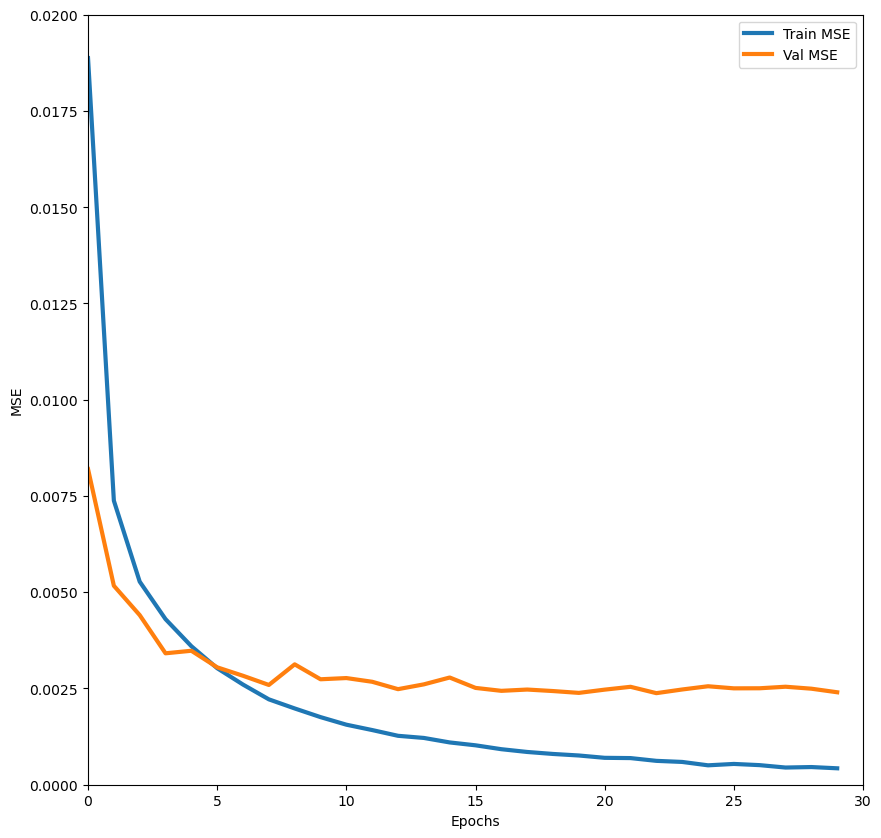

In [25]:
# GRÁFICO DE ERROR
f = plt.figure(figsize=(10,10))
plt.plot(history.history['mse'], linewidth=3, label='Train MSE')
plt.plot(history.history['val_mse'], linewidth=3, label='Val MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.axis([0, 30, 0, 0.02])
plt.legend(loc='upper right')
plt.show()

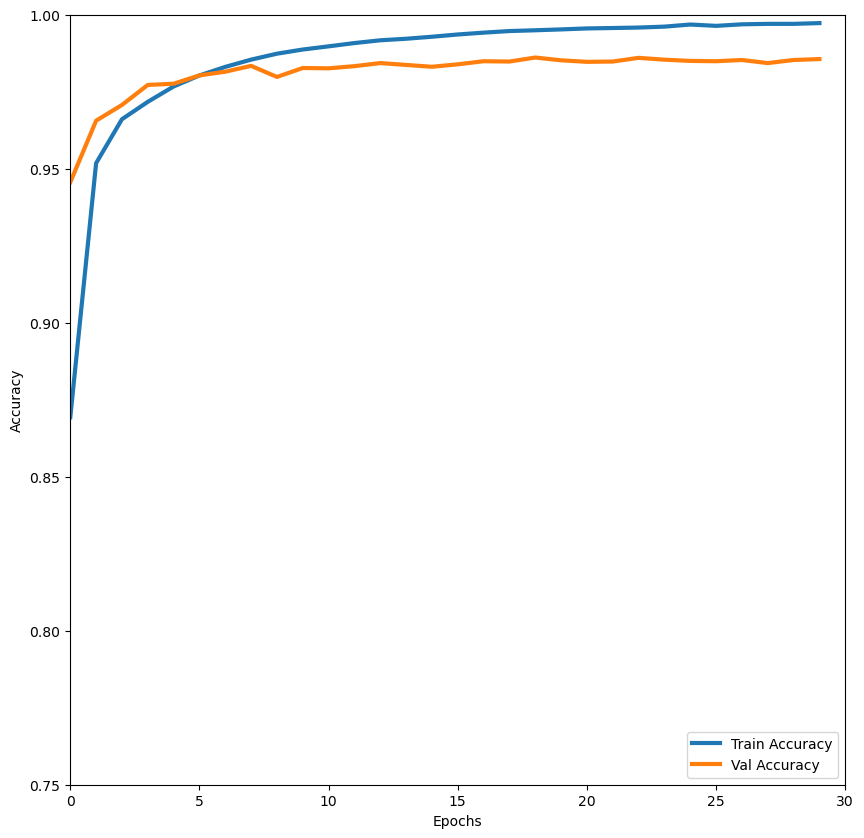

In [26]:
# GRÁFICO DE ACCURACY
f = plt.figure(figsize=(10,10))
plt.plot(history.history['acc'], linewidth=3, label='Train Accuracy')
plt.plot(history.history['val_acc'], linewidth=3, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.axis([0, 30, 0.75, 1])
plt.legend(loc='lower right')

# Hay un OVERFITING: en algún punto sobreajustaron el conjunto 
# de entrenamiento y llegamos a un valor asintótico.
# si aumento los valores de las epocs no consigo mejores rtados

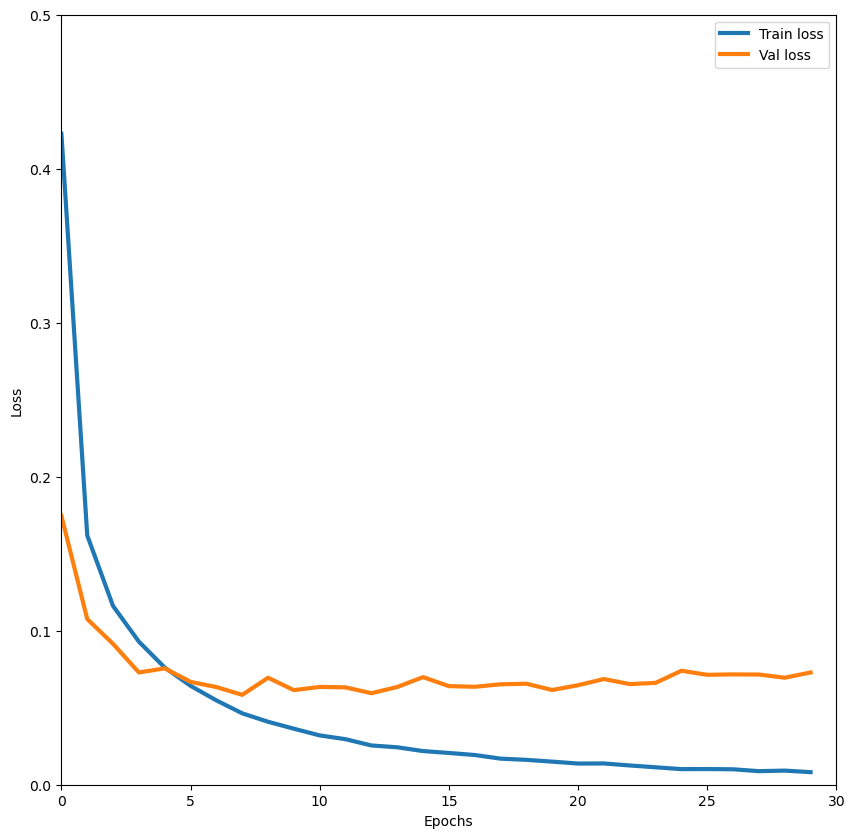

In [27]:
f = plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], linewidth=3, label='Train loss')
plt.plot(history.history['val_loss'], linewidth=3, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.axis([0, 30, 0, 0.5])
plt.legend(loc='upper right')

## Predicciones sobre una imagen individual

In [ ]:
# Ajusta un dato en el cual queremos hacer una predicción
x_single_test = x_train[0] # primera imagen del dataset, visualizada arriba
y_single_test = y_train[0] # primera etiqueta del dataset, visualizada arriba

# Modifico las dimensiones
x_single_test.shape = (1, x_single_test.shape[0])
y_single_test.shape = (1, y_single_test.shape[0])

In [ ]:
model.predict(x_single_test, verbose=1)

In [ ]:
# Evalúo la presicion de la red con respecto a esta presicion
# Obtenemos una presicion del 100%
model.evaluate(x_single_test, y_single_test,verbose=1)